# PAMAP2 Dataset Training and Inference with Dense and CNN Network

Made by STMicroelectronics


Authors: Fabrizio Maria Aymone, Danilo Pau

contact: danilo.pau@st.com

### Download PAMAP2 Dataset

In [1]:
!wget https://archive.ics.uci.edu/ml/machine-learning-databases/00231/PAMAP2_Dataset.zip

'wget' is not recognized as an internal or external command,
operable program or batch file.


In [2]:
!unzip PAMAP2_Dataset.zip

'unzip' is not recognized as an internal or external command,
operable program or batch file.


## Load Dataset and preprocesing

In [3]:
# Column names of the data
columns = ['time_stamp', 'activity_id', 'heart_rate', 'hand_temperature', 'hand_3D_acceleration_16_x',  'hand_3D_acceleration_16_y',
         'hand_3D_acceleration_16_z', 'hand_3D_acceleration_6_x', 'hand_3D_acceleration_6_y', 'hand_3D_acceleration_6_z', 'hand_3D_gyroscope_x',
         'hand_3D_gyroscope_y',  'hand_3D_gyroscope_z', 'hand_3D_magnetometer_x', 'hand_3D_magnetometer_y', 'hand_3D_magnetometer_z',
         'hand_4D_orientation_x', 'hand_4D_orientation_y', 'hand_4D_orientation_z', 'hand_4D_orientation_w', 'chest_temperature', 'chest_3D_acceleration_16_x',
         'chest_3D_acceleration_16_y', 'chest_3D_acceleration_16_z', 'chest_3D_acceleration_6_x', 'chest_3D_acceleration_6_y',  'chest_3D_acceleration_6_z',
         'chest_3D_gyroscope_x', 'chest_3D_gyroscope_y', 'chest_3D_gyroscope_z', 'chest_3D_magnetometer_x', 'chest_3D_magnetometer_y',
         'chest_3D_magnetometer_z', 'chest_4D_orientation_x', 'chest_4D_orientation_y', 'chest_4D_orientation_z', 'chest_4D_orientation_w',
         'ankle_temperature', 'ankle_3D_acceleration_16_x', 'ankle_3D_acceleration_16_y', 'ankle_3D_acceleration_16_z', 'ankle_3D_acceleration_6_x',
         'ankle_3D_acceleration_6_y', 'ankle_3D_acceleration_6_z', 'ankle_3D_gyroscope_x', 'ankle_3D_gyroscope_y', 'ankle_3D_gyroscope_z',
         'ankle_3D_magnetometer_x', 'ankle_3D_magnetometer_y', 'ankle_3D_magnetometer_z', 'ankle_4D_orientation_x', 'ankle_4D_orientation_y',
         'ankle_4D_orientation_z', 'ankle_4D_orientation_w']

# sensors measurements related to the 3 different carry positions (i.e. chest, hand, ankle)

chest = ['activity_id','chest_3D_acceleration_16_x','chest_3D_acceleration_16_y','chest_3D_acceleration_16_z', 'chest_3D_gyroscope_x', 'chest_3D_gyroscope_y', 'chest_3D_gyroscope_z']
ankle = ['activity_id','ankle_3D_acceleration_16_x','ankle_3D_acceleration_16_y','ankle_3D_acceleration_16_z', 'ankle_3D_gyroscope_x', 'ankle_3D_gyroscope_y', 'ankle_3D_gyroscope_z']
hand = ['activity_id','hand_3D_acceleration_16_x','hand_3D_acceleration_16_y','hand_3D_acceleration_16_z', 'hand_3D_gyroscope_x', 'hand_3D_gyroscope_y', 'hand_3D_gyroscope_z']

acc_scale = 16 * 9.80665 # from +/-16g
gyro_scale = 2000 # from +/-2000 °/s
acc_bit = 13
gyro_bit = 16

scale_acc = acc_scale*2/(2**acc_bit-1)
scale_gyro = gyro_scale*2/(2**gyro_bit-1)

# path related to the dataset folder

root = './PAMAP2_Dataset/Protocol/'

# frame size and slide size

window_size = 24
slide = 12

In [4]:
def name(list):
    if list==chest:
        name = "chest"
    elif list==hand:
        name = "hand"
    elif list==ankle:
        name = "ankle"
    else:
        raise "ERROR"
    
    return name

In [5]:
import pandas as pd

# users should be a list with selected users numbers (e.g. [1, 2, 3])

def load_subjects(folder, users):
    data = pd.DataFrame()
    users = [x+100 for x in users]
    for i in users:
        path = folder + "subject" + str(i) + ".dat"
        df = pd.read_table(path, header=None, sep='\s+')
        df.columns = columns
        df['id'] = i
        data = pd.concat([data, df], ignore_index=True)

    data = data.reset_index(drop=True)
    
    return data

In [6]:
data = load_subjects('./PAMAP2_Dataset/Protocol/', [1])

In [7]:
import numpy as np
np.unique(data["activity_id"])

array([ 0,  1,  2,  3,  4,  5,  6,  7, 12, 13, 16, 17, 24])

In [8]:
import sklearn
#import imblearn
from sklearn.preprocessing import StandardScaler
import numpy as np
    
def preprocess(position, users, folder):

    data = load_subjects(folder, users)
    df = data[position]
    df = df.dropna()
    df = df.drop(df.loc[df['activity_id']==0].index)
    label = sklearn.preprocessing.LabelEncoder()
    df['label'] = label.fit_transform(df['activity_id'])
    X = df.loc[:,position[1:7]]
    y = df.loc[:,"label"]
    # over_sampler = imblearn.over_sampling.RandomOverSampler(random_state=42)
    # X, y = over_sampler.fit_resample(df, df['label'])
    #int16 symmetriquantization
    X[position[1:4]] = np.round(X[position[1:4]]/scale_acc).astype(np.int16)
    X[position[4:7]] = np.round(X[position[4:7]]/scale_gyro).astype(np.int16)
    df = pd.DataFrame(X)
    df['label'] = y
    return df

In [9]:
import tensorflow as tf
import numpy as np
import scipy
from tensorflow import keras
from itertools import chain
import gc

class CustomWindowGenerator(keras.utils.Sequence):

    def __init__(self, X, y, index_array=None, window_size=256, batch_size=64, slide=50, shuffle=True, pass_array=False):
        
        # X and y are lists of datasets e.g. if we have two datasets (X1, y1) and (X2, y2), X is [X1, X2] and y is [y1, y2]
        
        self.X = X
        self.y = y
        self.w = window_size
        self.batch_size = batch_size
        self.slide = slide
        self.shuffle = shuffle
        self.index_array= np.array(list(chain(*[zip(np.repeat(idx, len(x)), np.arange(0, (len(x)-window_size+1), slide)) for idx, x in enumerate(X)])) if pass_array==False else index_array)
        if self.shuffle:
            np.random.shuffle(self.index_array)
        #self.epoch=1

    def on_epoch_end(self):
        if self.shuffle:
            np.random.shuffle(self.index_array)
        gc.collect()
        keras.backend.clear_session()
    
    def __getitem__(self, index):

        X_d = []
        y_d = []
        
        for n, i in self.index_array[index*self.batch_size:index*self.batch_size + self.batch_size]:
            
            X_d.append([self.X[n][i:i+self.w]])
            y_d.append(scipy.stats.mode(self.y[n][i:i+self.w])[0])
        
        return np.vstack(X_d), np.vstack(y_d)
    
    def __len__(self):
        return len(self.index_array)//self.batch_size

2024-05-22 10:01:20.450334: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-05-22 10:01:20.686067: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-05-22 10:01:20.686101: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-05-22 10:01:20.717663: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-05-22 10:01:20.814005: I tensorflow/core/platform/cpu_feature_guar

# Dense Models

In [10]:
def get_dense_model(num_classes):

    gc.collect()
    keras.backend.clear_session()
    
    
    model = keras.Sequential([
            keras.layers.Input((24,6)),
            keras.layers.Dense(128),
            keras.layers.BatchNormalization(),
            keras.layers.ReLU(),
            keras.layers.Dense(64),
            keras.layers.BatchNormalization(),
            keras.layers.ReLU(),
            keras.layers.Dense(128),
            keras.layers.BatchNormalization(),
            keras.layers.ReLU(),
            keras.layers.Flatten(),
            keras.layers.Dense(32),
            keras.layers.BatchNormalization(),
            keras.layers.ReLU(),
            keras.layers.Dense(num_classes, activation = 'softmax'),
            ])

    return model

In [11]:
from qkeras import *

def get_dense_quantized_model(num_classes):

        gc.collect()
        keras.backend.clear_session()
    
    
        #qkeras model

        quantized_model = keras.Sequential([
                        keras.layers.Input(shape=(24,6)),
                        QDense(128, kernel_quantizer="quantized_bits(8)"),
                        keras.layers.BatchNormalization(),
                        QActivation("quantized_relu(8)"),
                        QDense(64, kernel_quantizer="quantized_bits(8)"),
                        keras.layers.BatchNormalization(),
                        QActivation("quantized_relu(8)"),
                        QDense(128, kernel_quantizer="quantized_bits(8)"),
                        keras.layers.BatchNormalization(),
                        QActivation("quantized_relu(8)"),
                        keras.layers.Flatten(),
                        QDense(32, kernel_quantizer="quantized_bits(8)"),
                        keras.layers.BatchNormalization(),
                        QActivation("quantized_relu(8)"),
                        QDense(num_classes, kernel_quantizer="quantized_bits(8)"),
                        keras.layers.Activation('softmax'),
                        ])

        return quantized_model

## Training loop with 5-fold validation

In [12]:
import os
import sklearn.model_selection
# training hyperparameters

batch_size = 64 
epochs = 100

def train(position, users, folder):

        df = preprocess(position, users, folder) 
        X = df[position[1:6+1]].values
        y = df[["label"]].values

        num_classes = len(np.unique(y))
        print("Number of classes: ", num_classes)
        
        one_hot_y = keras.utils.to_categorical(y, num_classes)

        kfold = sklearn.model_selection.StratifiedShuffleSplit(n_splits=5, test_size=0.2, train_size=0.8, random_state=42)
        
        fold = 1
        
        results_k = []
        results_tflite = []
        results_qk = []


        index_array = np.array(list(chain(*[zip(np.repeat(idx, len(x)), np.arange(0, (len(x)-window_size+1), slide)) for idx, x in enumerate([X])])))
        
        y_index_array = []
        for _, i in index_array:
                y_index_array.append(scipy.stats.mode(y[i:i+window_size])[0])    
        

        train_index_array, test_index_array = sklearn.model_selection.train_test_split(index_array, test_size=0.2, random_state=42, shuffle=True, stratify=y_index_array)
        
        test_gen = CustomWindowGenerator([X], [one_hot_y], index_array=test_index_array, window_size=window_size, batch_size=batch_size, slide=slide, shuffle=True, pass_array=True)

        X_test_lite = []
        y_test_lite = []

        for _,i in test_index_array:
                X_test_lite.append(X[i:i+window_size])
                y_test_lite.append(scipy.stats.mode(y[i:i+window_size])[0])
        
        X_test_lite = np.asarray(X_test_lite, dtype=np.float32)
        y_test_lite = np.asarray(y_test_lite, dtype=np.int8)

        # K fold validation 5 steps

        for train_idx, val_idx in kfold.split(X = np.zeros(len(train_index_array)), y = y[train_index_array[:,1]]):
                

                train_gen = CustomWindowGenerator([X], [one_hot_y], index_array=train_index_array[train_idx], window_size=window_size, batch_size=batch_size, slide=slide, shuffle=True, pass_array=True)
                val_gen = CustomWindowGenerator([X], [one_hot_y], index_array=train_index_array[val_idx], window_size=window_size, batch_size=batch_size, slide=slide, shuffle=True, pass_array=True)
                
                model = get_dense_model(num_classes)

                model.compile(loss="categorical_crossentropy", optimizer='adam', metrics = ['accuracy'])
                
                print("K fold validation step:",fold)

                # model callbacks
                earlyStopping = keras.callbacks.EarlyStopping(monitor='val_loss', patience=10, verbose=0, mode='min')

                keras_models_dir = "dense/keras_models/"
                os.makedirs(keras_models_dir, exist_ok=True)
                mcp_path = keras_models_dir+'model_best_'+str(users[0])+'_'+name(position)+'_k_fold_'+str(fold)+'.h5'
                mcp_save =keras.callbacks.ModelCheckpoint(mcp_path, save_best_only=True, monitor='val_loss', mode='min')
                
                reduce_lr_loss = keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, verbose=1, min_delta=0.0001, mode='auto', cooldown=0, min_lr=0)
                
                # model training
                
                model.fit(train_gen, validation_data=val_gen, epochs=epochs, batch_size=batch_size, verbose=1, callbacks=[earlyStopping, reduce_lr_loss, mcp_save])
                
                model = keras.models.load_model(mcp_path)
               
                #evaluating the model on test data

                result = model.evaluate(test_gen)
                print("\n\n*****************************************keras model accuracy {} result: {}*****************************************".format(fold, result[1]))
                results_k.append(result[1])


                        



                def representative_data_gen():
                        repr_index_array = np.arange(0, len(X)-window_size+1, slide)
                        np.random.shuffle(repr_index_array)
                        for i in range(100):
                                j = repr_index_array[i]
                                yield [np.expand_dims(X[j:j+window_size].astype(np.float32), axis=0)]


                # load best keras model to tensorflow liet converter for tflite conversion and quantization
                converter = tf.lite.TFLiteConverter.from_keras_model(model)
                converter.optimizations = [tf.lite.Optimize.DEFAULT]
                converter.representative_dataset = representative_data_gen
                # Ensure that if any ops can't be quantized, the converter throws an error
                converter.target_spec.supported_ops = [tf.lite.OpsSet.TFLITE_BUILTINS_INT8]
                # Set the input and output tensors to float32 and int8 (APIs added in r2.3)
                converter.inference_input_type = tf.float32
                converter.inference_output_type = tf.int8

                tflite_model_quant = converter.convert()

                tflite_models_dir = "dense/tflite_models/"
                os.makedirs(tflite_models_dir, exist_ok=True)
                tflite_model_path = tflite_models_dir+"tflite"+'_'+str(name(position))+'_'+str(fold)+'.tflite'

                with open(tflite_model_path, 'wb') as f:
                        f.write(tflite_model_quant)
        
                # Input and output details

                tflite_interpreter = tf.lite.Interpreter(model_path=tflite_model_path)
                input_details = tflite_interpreter.get_input_details()
                output_details = tflite_interpreter.get_output_details()
                tflite_interpreter.resize_tensor_input(input_details[0]['index'], (X_test_lite.shape))
                tflite_interpreter.allocate_tensors()

                #quantize
                scale, zero_point = input_details[0]["quantization"]

                tflite_interpreter.set_tensor(input_details[0]['index'], X_test_lite)

                tflite_interpreter.invoke()

                scale, zero_point = output_details[0]['quantization']

                tflite_model_predictions = tflite_interpreter.get_tensor(output_details[0]['index'])

                y_pred = tflite_model_predictions
                y_pred = (tflite_model_predictions.astype(np.int8))
                result = sklearn.metrics.accuracy_score(np.squeeze(y_test_lite), y_pred.argmax(axis=1))
                print("*****************************************TFlite model accuracy score: "+str(result)+"*****************************************\n\n")
                results_tflite.append(result)







                qmodel = get_dense_quantized_model(num_classes)

                qmodel.compile(loss="categorical_crossentropy", optimizer='adam', metrics = ['accuracy'])

                # model callbacks
                earlyStopping = keras.callbacks.EarlyStopping(monitor='val_loss', patience=10, verbose=0, mode='min')

                qkeras_models_dir = "dense/qkeras_models/"
                os.makedirs(qkeras_models_dir, exist_ok=True)
                mcp_path = qkeras_models_dir+'model_best_'+str(users[0])+'_'+name(position)+'_k_fold_'+str(fold)+'.h5'
                mcp_save = keras.callbacks.ModelCheckpoint(mcp_path, save_best_only=True, monitor='val_loss', mode='min')
                
                reduce_lr_loss = keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, verbose=1, min_delta=0.0001, mode='auto', cooldown=0, min_lr=0)
                
                # model training
                
                qmodel.fit(train_gen, validation_data=val_gen, epochs=epochs, batch_size=batch_size, verbose=1, callbacks=[earlyStopping, reduce_lr_loss, mcp_save])
                
                qmodel.load_weights(mcp_path)

                #evaluating the model on test data

                result = qmodel.evaluate(test_gen)
                print("\n\n*****************************************qkeras model accuracy {} result: {}*****************************************".format(fold, result[1]))
                results_qk.append(result[1])
                fold+=1

        results_k, results_tflite, results_qk = np.asarray(results_k), np.asarray(results_tflite), np.asarray(results_qk)
        os.makedirs(f"./dense/results/{name(position)}", exist_ok=True)
        np.save(f"./dense/results/{name(position)}/results_keras.npy", results_k)
        np.save(f"./dense/results/{name(position)}/results_tflite.npy", results_tflite)
        np.save(f"./dense/results/{name(position)}/results_qkeras.npy", results_qk)

        return results_k, results_tflite, results_qk

In [13]:
train(chest, [1], './PAMAP2_Dataset/Protocol/')
train(ankle, [1], './PAMAP2_Dataset/Protocol/')
train(hand, [1], './PAMAP2_Dataset/Protocol/')

# CNN Models

In [14]:
def get_cnn_model(num_classes):

    gc.collect()
    keras.backend.clear_session()
    
    
    model = keras.Sequential([
        keras.layers.Input((24,6)),
        keras.layers.Reshape((6,4,6)),
        keras.layers.Conv2D(filters=8, kernel_size = (5,5), padding = "same"),
        keras.layers.BatchNormalization(),
        keras.layers.ReLU(),
        keras.layers.Conv2D(filters=8, kernel_size = (5,5), padding= "same"),
        keras.layers.BatchNormalization(),
        keras.layers.ReLU(),
        keras.layers.MaxPool2D(pool_size = 2),
        keras.layers.Flatten(),
        keras.layers.Dense(64),
        keras.layers.BatchNormalization(),
        keras.layers.ReLU(),
        keras.layers.Dense(num_classes, activation = 'softmax'),
        ]) 

    return model

In [15]:
from qkeras import *

def get_cnn_quantized_model(num_classes):

        gc.collect()
        keras.backend.clear_session()
    
    
        #qkeras model

        quantized_model = keras.Sequential([
                        keras.layers.Input((24,6)),
                        keras.layers.Reshape((6,4,6)),
                        QConv2D(filters=8, kernel_size = (5,5), padding = "same", kernel_quantizer="quantized_bits(8)"),
                        keras.layers.BatchNormalization(),
                        QActivation("quantized_relu(8)"),
                        QConv2D(filters=8, kernel_size = (5,5), padding = "same", kernel_quantizer="quantized_bits(8)"),
                        keras.layers.BatchNormalization(),
                        QActivation("quantized_relu(8)"),
                        keras.layers.MaxPool2D(pool_size = 2),
                        keras.layers.Flatten(),
                        QDense(64, kernel_quantizer="quantized_bits(8)"),
                        keras.layers.BatchNormalization(),
                        QActivation("quantized_relu(8)"),
                        QDense(num_classes, kernel_quantizer="quantized_bits(8)"),
                        keras.layers.Activation('softmax'),
                        ])

        return quantized_model
    

In [16]:
import os
import sklearn.model_selection

# training hyperparameters

batch_size = 64 
epochs = 100

def train(position, users, folder):

        df = preprocess(position, users, folder) 
        X = df[position[1:6+1]].values
        y = df[["label"]].values

        num_classes = len(np.unique(y))
        print("Number of classes: ", num_classes)
        
        one_hot_y = keras.utils.to_categorical(y, num_classes)

        kfold = sklearn.model_selection.StratifiedShuffleSplit(n_splits=5, test_size=0.2, train_size=0.8, random_state=1)
        
        fold = 1
        
        results_k = []
        results_tflite = []
        results_qk = []


        index_array = np.array(list(chain(*[zip(np.repeat(idx, len(x)), np.arange(0, (len(x)-window_size+1), slide)) for idx, x in enumerate([X])])))
        
        y_index_array = []
        for _, i in index_array:
                y_index_array.append(scipy.stats.mode(y[i:i+window_size])[0])    
        

        train_index_array, test_index_array = sklearn.model_selection.train_test_split(index_array, test_size=0.2, random_state=42, shuffle=True, stratify=y_index_array)
        
        test_gen = CustomWindowGenerator([X], [one_hot_y], index_array=test_index_array, window_size=window_size, batch_size=batch_size, slide=slide, shuffle=True, pass_array=True)

        X_test_lite = []
        y_test_lite = []

        for _,i in test_index_array:
                X_test_lite.append(X[i:i+window_size])
                y_test_lite.append(scipy.stats.mode(y[i:i+window_size])[0])
        
        X_test_lite = np.asarray(X_test_lite, dtype=np.float32)
        y_test_lite = np.asarray(y_test_lite, dtype=np.int8)

        # K fold validation 5 steps

        for train_idx, val_idx in kfold.split(X = np.zeros(len(train_index_array)), y = y[train_index_array[:,1]]):
                

                train_gen = CustomWindowGenerator([X], [one_hot_y], index_array=train_index_array[train_idx], window_size=window_size, batch_size=batch_size, slide=slide, shuffle=True, pass_array=True)
                val_gen = CustomWindowGenerator([X], [one_hot_y], index_array=train_index_array[val_idx], window_size=window_size, batch_size=batch_size, slide=slide, shuffle=True, pass_array=True)
                
                model = get_cnn_model(num_classes)

                model.compile(loss="categorical_crossentropy", optimizer='adam', metrics = ['accuracy'])
                
                print("K fold validation step:",fold)

                # model callbacks
                earlyStopping = keras.callbacks.EarlyStopping(monitor='val_loss', patience=10, verbose=0, mode='min')

                keras_models_dir = "cnn/keras_models/"
                os.makedirs(keras_models_dir, exist_ok=True)
                mcp_path = keras_models_dir+'model_best_'+str(users[0])+'_'+name(position)+'_k_fold_'+str(fold)+'.h5'
                mcp_save = keras.callbacks.ModelCheckpoint(mcp_path, save_best_only=True, monitor='val_loss', mode='min')
                
                reduce_lr_loss = keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, verbose=1, min_delta=0.0001, mode='auto', cooldown=0, min_lr=0)
                
                # model training
                print("ok")
                
                model.fit(train_gen, validation_data=val_gen, epochs=epochs, batch_size=batch_size, verbose=5, callbacks=[earlyStopping, reduce_lr_loss, mcp_save])
                
                model = keras.models.load_model(mcp_path)

                #evaluating the model on test data

                result = model.evaluate(test_gen)
                print("\n\n*****************************************keras validation {} result: {}*****************************************".format(fold, result[1]))
                results_k.append(result[1])


                        



                def representative_data_gen():
                        repr_index_array = np.arange(0, len(X)-window_size+1, slide)
                        np.random.shuffle(repr_index_array)
                        for i in range(100):
                                j = repr_index_array[i]
                                yield [np.expand_dims(X[j:j+window_size].astype(np.float32), axis=0)]


                # load best keras model to tensorflow liet converter for tflite conversion and quantization
                converter = tf.lite.TFLiteConverter.from_keras_model(model)
                converter.optimizations = [tf.lite.Optimize.DEFAULT]
                converter.representative_dataset = representative_data_gen
                # Ensure that if any ops can't be quantized, the converter throws an error
                converter.target_spec.supported_ops = [tf.lite.OpsSet.TFLITE_BUILTINS_INT8]
                # Set the input and output tensors to float32 and int8 (APIs added in r2.3)
                converter.inference_input_type = tf.float32
                converter.inference_output_type = tf.int8

                tflite_model_quant = converter.convert()

                tflite_models_dir = "cnn/tflite_models/"
                os.makedirs(tflite_models_dir, exist_ok=True)
                tflite_model_path = tflite_models_dir+"tflite"+'_'+str(name(position))+'_'+str(fold)+'.tflite'

                with open(tflite_model_path, 'wb') as f:
                        f.write(tflite_model_quant)
        
                # Input and output details

                tflite_interpreter = tf.lite.Interpreter(model_path=tflite_model_path)
                input_details = tflite_interpreter.get_input_details()
                output_details = tflite_interpreter.get_output_details()
                tflite_interpreter.resize_tensor_input(input_details[0]['index'], (X_test_lite.shape))
                tflite_interpreter.allocate_tensors()

                #quantize
                scale, zero_point = input_details[0]["quantization"]

                tflite_interpreter.set_tensor(input_details[0]['index'], X_test_lite)

                tflite_interpreter.invoke()

                scale, zero_point = output_details[0]['quantization']

                tflite_model_predictions = tflite_interpreter.get_tensor(output_details[0]['index'])

                y_pred = tflite_model_predictions
                y_pred = (tflite_model_predictions.astype(np.int8))
                result = sklearn.metrics.accuracy_score(np.squeeze(y_test_lite), y_pred.argmax(axis=1))
                print("*****************************************TFlite model accuracy score: "+str(result)+"*****************************************\n\n")
                results_tflite.append(result)







                qmodel = get_cnn_quantized_model(num_classes)

                qmodel.compile(loss="categorical_crossentropy", optimizer='adam', metrics = ['accuracy'])

                # model callbacks
                earlyStopping = keras.callbacks.EarlyStopping(monitor='val_loss', patience=10, verbose=0, mode='min')

                qkeras_models_dir = "cnn/qkeras_models/"
                os.makedirs(qkeras_models_dir, exist_ok=True)
                mcp_path = qkeras_models_dir+'model_best_'+str(users[0])+'_'+name(position)+'_k_fold_'+str(fold)+'.h5'
                mcp_save = keras.callbacks.ModelCheckpoint(mcp_path, save_best_only=True, monitor='val_loss', mode='min')
                
                reduce_lr_loss = keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, verbose=1, min_delta=0.0001, mode='auto', cooldown=0, min_lr=0)
                
                # model training
                
                qmodel.fit(train_gen, validation_data=val_gen, epochs=epochs, batch_size=batch_size, verbose=1, callbacks=[earlyStopping, reduce_lr_loss, mcp_save])
                
                qmodel.load_weights(mcp_path)

                #evaluating the model on test data

                result = qmodel.evaluate(test_gen)
                print("\n\n*****************************************qkeras validation {} result: {}*****************************************".format(fold, result[1]))
                results_qk.append(result[1])
                
                fold+=1

        results_k, results_tflite, results_qk = np.asarray(results_k), np.asarray(results_tflite), np.asarray(results_qk)
        os.makedirs(f"./cnn/results/{name(position)}", exist_ok=True)
        np.save(f"./cnn/results/{name(position)}/results_keras.npy", results_k)
        np.save(f"./cnn/results/{name(position)}/results_tflite.npy", results_tflite)
        np.save(f"./cnn/results/{name(position)}/results_qkeras.npy", results_qk)

        return results_k, results_tflite, results_qk

In [17]:
train(chest, [1], './PAMAP2_Dataset/Protocol/')
train(ankle, [1], './PAMAP2_Dataset/Protocol/')
train(hand, [1], './PAMAP2_Dataset/Protocol/')

# Final results

In [168]:
from matplotlib import pyplot as plt

from tabulate import tabulate
import numpy as np
from matplotlib import pyplot as plt
import matplotlib
import scienceplots

plt.style.use(['science','ieee', 'no-latex'])


positions = ["chest", "ankle", "hand"]
def plot_metrics(results, title):

    fig, axs = plt.subplots(1, len(positions), figsize=(12, 3))
    fig.subplots_adjust(top=0.8)
    for ax, pos in enumerate(positions):
        keras_acc = np.asarray(results[pos])[0][0]
        tflite_acc = np.asarray(results[pos])[0][1]
        qkeras_acc = np.asarray(results[pos])[0][2]

        x = [0, 1, 2]
        labels = ["Keras", "TFlite", "QKeras"]

        axs[ax].errorbar(x, [np.average(keras_acc), np.average(tflite_acc), np.average(qkeras_acc)], yerr=[np.std(keras_acc), np.std(tflite_acc), np.std(qkeras_acc)], capsize=3, fmt="r--o",ms=3, ecolor = "black")
        print(np.average(keras_acc), np.average(tflite_acc), np.average(qkeras_acc), np.std(keras_acc), np.std(tflite_acc), np.std(qkeras_acc))
        axs[ax].set_xticks(x, labels, rotation="horizontal")
        axs[ax].set_title(pos)
    #fig.suptitle(title, fontsize=16, y=0.95)
    fig.text(0.07, 0.5, 'Accuracy', va='center', rotation='vertical', fontsize=10)
    plt.plot()

## Dense

In [169]:
example = "./dense/keras_models/model_best_1_hand_k_fold_1.h5"
model = keras.models.load_model(example)
model.summary()

NameError: name 'keras' is not defined

In [170]:
example = "./dense/qkeras_models/model_best_1_chest_k_fold_1.h5"
qmodel = get_dense_quantized_model(12) #the classes are 12
qmodel.load_weights(example)
qmodel.summary()

NameError: name 'get_dense_quantized_model' is not defined

In [173]:
dense_results = {"chest":[], "ankle":[], "hand":[]}

for pos in dense_results.keys():
    dense_results[pos].append([np.load(f"./dense/results/{pos}/results_keras.npy"), np.load(f"./dense/results/{pos}/results_tflite.npy"), np.load(f"./dense/results/{pos}/results_qkeras.npy")])

0.9069230794906616 0.8516702715693343 0.9044230699539184 0.000878641182626613 0.02101693637526449 0.0014310512345965243
0.868798828125 0.7683702989392478 0.8744140625 0.005797196124865557 0.01710914308254115 0.004336091459822915
0.8759765625 0.8709630702389571 0.874609375 0.0034457575711674513 0.0020401203581091394 0.0030123431279662463


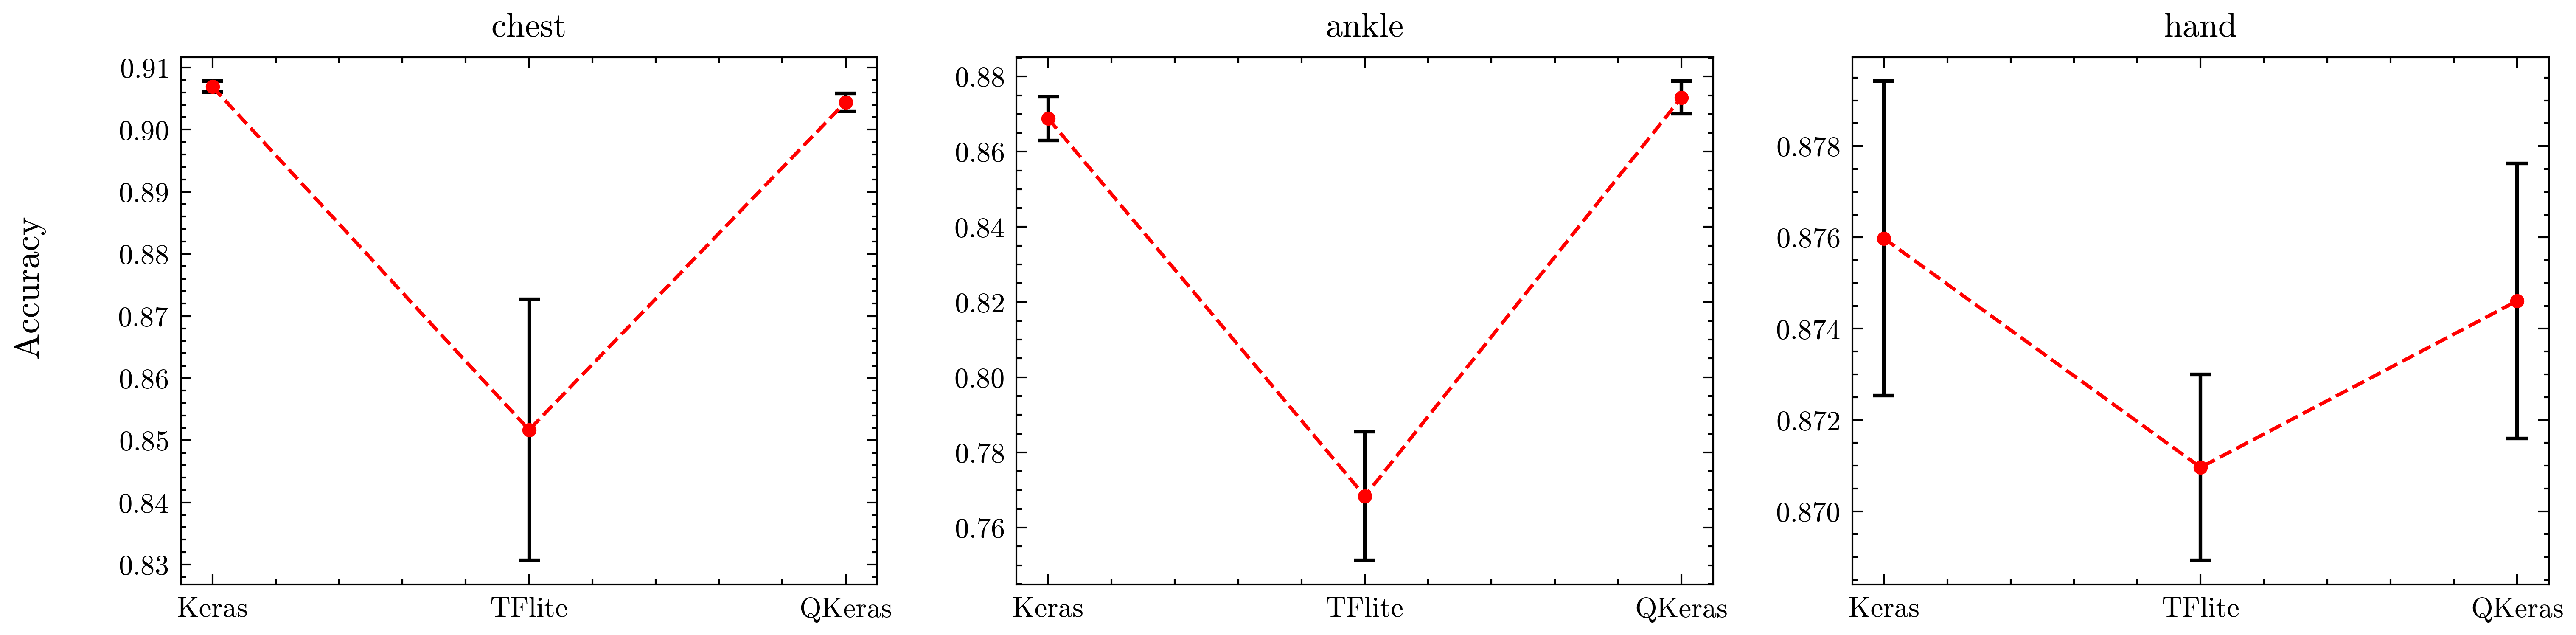

In [174]:
plot_metrics(dense_results, "Dense")

## CNN

In [175]:
example = "./cnn/keras_models/model_best_1_chest_k_fold_1.h5"
model = keras.models.load_model(example)
model.summary()

NameError: name 'keras' is not defined

In [176]:
xample = "./cnn/qkeras_models/model_best_1_chest_k_fold_1.h5"
qmodel = get_cnn_quantized_model(12) #the classes are 12
qmodel.load_weights(example)
qmodel.summary()

NameError: name 'get_cnn_quantized_model' is not defined

In [178]:
cnn_results = {"chest":[], "ankle":[], "hand":[]}

for pos in cnn_results.keys():
    cnn_results[pos].append([np.load(f"./cnn/results/{pos}/results_keras.npy"), np.load(f"./cnn/results/{pos}/results_tflite.npy"), np.load(f"./cnn/results/{pos}/results_qkeras.npy")])

0.8877403736114502 0.8765681326604181 0.8830288529396058 0.0013850880039489517 0.00284602188763998 0.003073149267353348
0.83603515625 0.8058823529411765 0.8212890625 0.004638928858013133 0.007898306005324101 0.0051281155676234855
0.864697265625 0.8631426502534396 0.847216796875 0.001729094844690017 0.0026616555640048786 0.004436109728021048


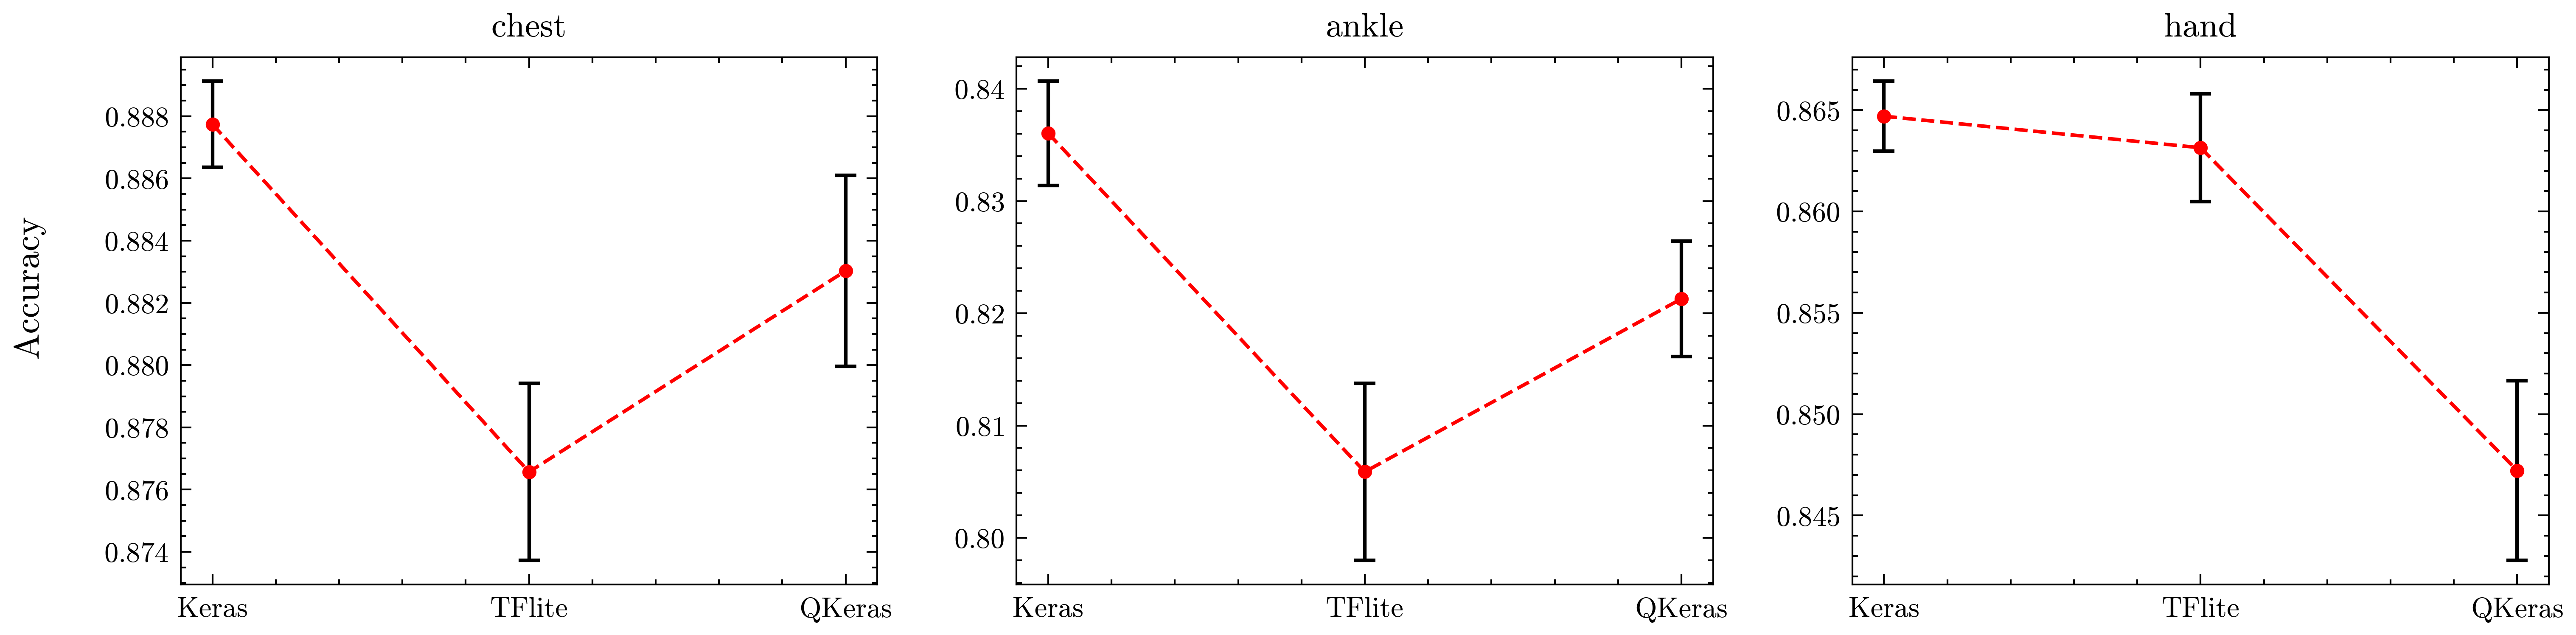

In [179]:
plot_metrics(cnn_results, "CNN")